In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
if platform  == 'win32':
    sys.argv=["_", r"P:\rmahajan14\ndte_data\muni_data", "20170101", "20190930"]
if platform == 'linux' or platform == 'linux2':
    def full_path(p):
        return os.path.abspath(os.path.expanduser(p))
    sys.argv=["_", r"/mnt/d/DiDi_Ride_Data/data", r"/mnt/d/DiDi_Ride_Data/Ride_Data_Cache"]

In [3]:
from loader1 import *
from utils import *
from common import *
from experiment2 import *
# from sys import platform

In [4]:
merged_orders = merge_order_df()

../Ride_Data_Cache/merged_orders.msgpack exists


In [5]:
merged_orders

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
0,00003ad9f837aca8ecdb9ae0729d0866,2016-11-01 14:35:44,2016-11-01 14:48:01,104.107101,30.699385,104.054980,30.688850,12.283333,64ee983f9979db09cb2586ec3893c467
1,0000c5bb7976b3dfe0fefa060265bdca,2016-11-01 15:06:22,2016-11-01 15:33:26,104.065170,30.702790,104.068280,30.666830,27.066667,19aa2c3cb2b05daf4ed06a3849c2c43c
2,0000f2c8aa21f2599a82923f317334bc,2016-11-01 19:38:49,2016-11-01 19:50:28,104.050859,30.687837,104.057100,30.662350,11.650000,15045dc2301012dda9cb8e98f4723efd
3,000102a3f8b31b3bc888572108888727,2016-11-01 11:22:02,2016-11-01 11:50:06,104.012450,30.622080,104.049190,30.755740,28.066667,53332bf0536f84453f0ab40a91774101
4,00017e395c1e449231b86f9149a793e5,2016-11-01 00:19:20,2016-11-01 00:34:41,104.092920,30.685830,103.990711,30.670803,15.350000,0dafbd548725f540988c5aa2554d782e
...,...,...,...,...,...,...,...,...,...
215023,fffe5967b6fdeab48c68f0ca2b330d61,2016-11-30 17:51:34,2016-11-30 18:47:20,103.897790,30.806530,104.042230,30.666520,55.766667,b7a5478a20a23993fde23f7cba244015
215024,fffe9e5c6d8030fd62448b8e53aacf47,2016-11-30 03:50:50,2016-11-30 04:22:22,104.073740,30.663010,103.928100,30.777570,31.533333,c6b7b37206ee6c6a38bb88a7c1655283
215025,fffeb486c95ea127189ae560038c6c3a,2016-11-30 12:27:08,2016-11-30 13:10:21,104.073912,30.695677,104.053270,30.765540,43.216667,d242eea3b731a2d1be5ecbd217fbe971
215026,ffff5cc2253bf6bca72dcb1e8a1958e6,2016-11-30 15:38:33,2016-11-30 15:49:03,104.113684,30.649077,104.099270,30.667460,10.500000,8e64c70c1c85b58dfcf79e7f939a8e17


### Remove rides with ride times greater than 3 hours

In [6]:
merged_orders = merged_orders[merged_orders.ride_duration <= 180]

In [7]:
merged_orders.shape

(6104724, 9)

In [8]:
merged_orders['hour'] = merged_orders.ride_start_timestamp.dt.hour
# merged_orders['offpeak'] = (merged_orders.hour < 8) | (merged_orders.hour > 21) 

In [9]:
merged_orders.columns

Index(['order_id', 'ride_start_timestamp', 'ride_stop_timestamp',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'ride_duration', 'driver_id', 'hour'],
      dtype='object')

In [10]:
driver_start_times = merged_orders.loc[:, ['driver_id', 'ride_start_timestamp', 'ride_stop_timestamp', 'order_id']]\
            .drop_duplicates()
driver_start_times.sort_values(['driver_id', 'ride_start_timestamp'],
                               inplace=True)
# driver_start_times['stop_time_shifted'] = driver_start_times.groupby(
#     'driver_id')['ride_stop_timestamp'].shift(1)
# driver_start_times['diff'] = driver_start_times[
#     'ride_start_timestamp'] - driver_start_times['stop_time_shifted']

# driver_start_times_no_na = driver_start_times.dropna()
# driver_start_times_no_na['diff'] = driver_start_times_no_na['diff'].dt.total_seconds() / 60


In [11]:
driver_start_times['start_time_shifted'] = driver_start_times.groupby(
    'driver_id')['ride_start_timestamp'].shift(-1)

In [12]:
driver_start_times['diff'] = driver_start_times['start_time_shifted'] - driver_start_times['ride_stop_timestamp']

In [13]:
driver_start_times_no_na = driver_start_times.dropna()
driver_start_times_no_na['diff'] = driver_start_times_no_na['diff'].dt.total_seconds() / 60

In [14]:
driver_start_times_no_na['hour'] = driver_start_times_no_na.ride_stop_timestamp.dt.hour

In [16]:
tau = driver_start_times_no_na['diff'].median()
driver_start_times_no_na['new_diff'] = np.maximum(0, (driver_start_times_no_na['diff'] - tau))

In [17]:
stop_times = driver_start_times_no_na.ride_stop_timestamp
driver_start_times_no_na['total_hour'] = (stop_times.dt.hour * 3600 + stop_times.dt.minute * 60 + stop_times.dt.second) / 3600

In [18]:
driver_start_times_no_na

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,start_time_shifted,diff,hour,new_diff,total_hour
175165,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 11:57:05,2016-11-01 12:13:18,f727597b61fc2f0141aadecf2a3b5ee0,2016-11-01 12:33:05,19.783333,12,9.450000,12.221667
90347,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:33:05,2016-11-01 12:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 12:58:45,9.683333,12,0.000000,12.817778
64719,000042288ba964aa04d14869bd56efb6,2016-11-28 19:49:07,2016-11-28 20:00:58,504e0d59e3c0ae899a85c5e0551cb2b3,2016-11-28 20:10:49,9.850000,20,0.000000,20.016111
5326,000042288ba964aa04d14869bd56efb6,2016-11-28 20:10:49,2016-11-28 20:20:25,06c7c82d8b15810ce80c47d0d3243ee1,2016-11-28 20:27:49,7.400000,20,0.000000,20.340278
118578,000042288ba964aa04d14869bd56efb6,2016-11-28 20:27:49,2016-11-28 21:02:33,929d619cd18a44b9ecdd259d71a13f7f,2016-11-28 22:32:06,89.550000,21,79.216667,21.042500
...,...,...,...,...,...,...,...,...,...
144477,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 15:33:56,2016-11-26 15:45:53,a92e1feebe36eb6f916fb6402f7bf13a,2016-11-26 15:49:27,3.566667,15,0.000000,15.764722
80548,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 15:49:27,2016-11-26 16:19:59,5e7862e787250cf35f6b8ebef87c769c,2016-11-26 16:37:12,17.216667,16,6.883333,16.333056
121924,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 16:37:12,2016-11-26 16:52:46,8ee634ecfce0c55c9df74c009063ebc9,2016-11-26 17:55:19,62.550000,16,52.216667,16.879444
85069,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 17:55:19,2016-11-26 18:23:39,63bc8ec6f69cb8a3bf679151648d6f33,2016-11-26 18:29:48,6.150000,18,0.000000,18.394167


In [20]:
check = driver_start_times_no_na.groupby('hour')['new_diff'].agg(['count', 'mean']).reset_index()
check['count'] = check['count'] / 10**7

In [21]:
check

,hour,count,mean
0,0,0.007781,245.030099
1,1,0.007759,262.075905
2,2,0.005004,255.844033
3,3,0.003122,227.903142
4,4,0.002729,194.337907
5,5,0.002244,166.099800
6,6,0.003754,119.282536
7,7,0.013481,61.434551
8,8,0.027364,58.112775
9,9,0.030192,71.396935


In [22]:
check.describe()

,hour,count,mean
count,24.000000,24.000000,24.000000
mean,11.500000,0.020515,86.736405
std,7.071068,0.012087,87.038022
min,0.000000,0.002244,2.309619
25%,5.750000,0.007776,25.467578
50%,11.500000,0.025962,52.298478
75%,17.250000,0.030792,130.986852
max,23.000000,0.035749,262.075905


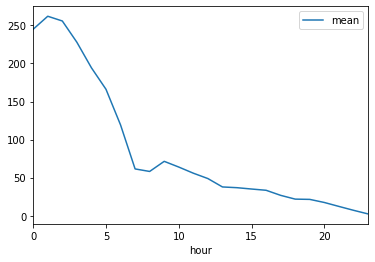

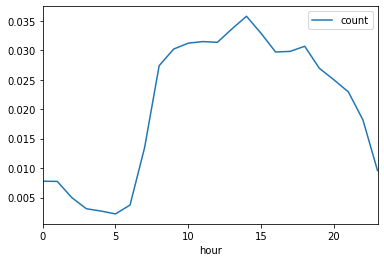

In [23]:
check.plot('hour', 'mean')
check.plot('hour', 'count')

In [49]:
mean = np.mean(check['count'])
std = np.std(check['hour'] * check['count'])

In [50]:
mean, std

(0.020515091666666666, 0.20458047418596467)

In [57]:
y

array([0.0077812, 0.0077587, 0.0050043, 0.0031215, 0.0027291, 0.0022436,
       0.0037541, 0.0134813, 0.0273642, 0.0301921, 0.0311874, 0.0314535,
       0.0313309, 0.0335992, 0.0357493, 0.0328528, 0.0296854, 0.0297935,
       0.0306602, 0.0269394, 0.0249843, 0.0229218, 0.0181741, 0.0096003])

In [56]:
y*(x-mean)**2

array([6.18714711e-04, 3.99999266e-03, 1.47706150e-02, 2.30604556e-02,
       3.77261374e-02, 4.99418416e-02, 1.22743024e-01, 6.08434811e-01,
       1.63002509e+00, 2.29471529e+00, 2.94533391e+00, 3.61324919e+00,
       4.30210658e+00, 5.43460249e+00, 6.72744656e+00, 7.11657496e+00,
       7.33395852e+00, 8.32704830e+00, 9.62509984e+00, 9.43860091e+00,
       9.71390133e+00, 9.83886759e+00, 8.57221937e+00, 4.95479476e+00])

In [53]:
# Fitting gaussian through points
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = list(check.index)
y = check['count'].values

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n  #note this correction

print(n, mean, sigma)

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

24 0.28198235416666667 4.2804100126953495


In [60]:
from scipy.stats import norm

In [62]:
mean,std=norm.fit(y)

In [63]:
mean, std

(0.020515091666666666, 0.011832032829742201)

In [59]:
popt

array([ 0.03550357, 14.4674348 ,  5.9197834 ])

In [44]:
# Fitting gaussian through points
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

x = list(check.index)
y = check['count'].values

# n = len(x)                          #the number of data
# mean = sum(x*y)/n                   #note this correction
# sigma = sum(y*(x-mean)**2)/n        #note this correction

mean1 = np.mean(check['count'])
sigma1 = np.var(check['count'])

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean1,sigma1])

In [45]:
popt

array([1.00000000e+00, 2.05150917e-02, 1.39997001e-04])

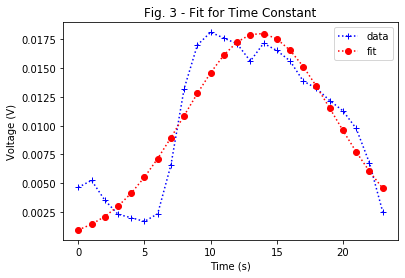

In [81]:
plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

In [80]:
popt, pcov

(array([ 0.01803478, 13.66440669,  5.63441769]),
 array([[ 1.03211715e-06, -1.72151693e-05, -2.43406438e-04],
        [-1.72151693e-05,  1.37465430e-01,  1.50187577e-02],
        [-2.43406438e-04,  1.50187577e-02,  1.60367897e-01]]))

In [74]:
# Get lambda for each t
from scipy.stats import norm
lmbd = norm.pdf(8.5, loc=mean, scale=std)
lmbd

0.0

In [94]:
####
driver_start_times_no_na['lmbd'] = gaus(driver_start_times_no_na['total_hour'],*popt)

In [159]:
yy = 50
idle_time = idle_time_est([yy, yy, yy], 10, 1./(10*gaus([1, 12, 24],*popt)))

In [160]:
 1./gaus([1, 12, 24], *popt)

array([693.32661587,  57.92120882, 298.24202405])

In [161]:
idle_time

array([-0.        , 39.67458431, 26.51626084])

In [163]:
def idle_time_est(t, tau, shape):
    # sample from time diff distribution
    t_s = tau + np.random.exponential(scale=shape)

    indicator = t <= t_s
    indicator = 1 - indicator
    i_time = t - t_s
    idle_time = indicator * i_time

    return idle_time

In [172]:
def create_modified_active_time_through_decay(orders, use_cache=True):
    cache_path = os.path.join(CACHE_DIR, f'new_idle_times.msgpack')
    if os.path.exists(cache_path) and use_cache:
        print(f'{cache_path} exists')
        driver_stats_updated = pd.read_msgpack(cache_path)

    else:
        print("Creating the exponential decay")
        driver_start_times = orders.loc[:, ['driver_id', 'ride_start_timestamp', 'ride_stop_timestamp', 'order_id']]\
            .drop_duplicates()

        driver_start_times.sort_values(['driver_id', 'ride_start_timestamp'],
                                       inplace=True)

        driver_start_times['start_time_shifted'] = driver_start_times.groupby(
            'driver_id')['ride_start_timestamp'].shift(-1)

        driver_start_times['diff'] = driver_start_times['start_time_shifted'] - driver_start_times['ride_stop_timestamp']

        driver_start_times_no_na = driver_start_times.dropna()

        driver_start_times_no_na['diff'] = driver_start_times_no_na['diff'].dt.total_seconds() / 60
        
        driver_start_times_no_na['hour'] = driver_start_times_no_na.ride_stop_timestamp.dt.hour

        tau = driver_start_times_no_na['diff'].median()

        driver_start_times_no_na['new_diff'] = np.maximum(0, (driver_start_times_no_na['diff'] - tau))

        stop_times = driver_start_times_no_na.ride_stop_timestamp
        driver_start_times_no_na['total_hour'] = (stop_times.dt.hour * 3600 + stop_times.dt.minute * 60 + stop_times.dt.second) / 3600

        # Modeling lambda
        stats_df = driver_start_times_no_na.groupby('hour')['new_diff'].agg(['count', 'mean']).reset_index()
        stats_df['count'] = stats_df['count'] / 10**7
        mean = np.mean(stats_df['count'])
        std = np.std(stats_df['count'])

        # Fit gaussian on counts
        from scipy.optimize import curve_fit
        from scipy import asarray as ar, exp

        x = list(stats_df.index)
        y = stats_df['count'].values

        n = len(x)  # the number of data
        mean = sum(x * y) / n  # note this correction
        sigma = sum(y * (x - mean) ** 2) / n  # note this correction

        def gaus(x, a, x0, sigma):
            return a * exp(-(x - x0) ** 2 / (2 * sigma ** 2))

        popt, pcov = curve_fit(gaus, x, y, p0=[1, mean, sigma])\

        # Find lambda for entire df
        driver_start_times_no_na['lmbd'] = gaus(driver_start_times_no_na['total_hour'], *popt)

        shape = 1. / driver_start_times_no_na['lmbd'].values

        driver_start_times_no_na['inactive_time'] = idle_time_est(driver_start_times_no_na['diff'], tau, shape)

        ##
        driver_day_min = pd.DataFrame(
            orders.groupby('driver_id')
            ['ride_start_timestamp'].min()).reset_index()
        driver_day_max = pd.DataFrame(
            orders.groupby('driver_id')
            ['ride_stop_timestamp'].max()).reset_index()
        driver_active_time = driver_day_min.merge(
            driver_day_max, on='driver_id', how='left')
        driver_active_time['active_time'] = (
            driver_active_time['ride_stop_timestamp'] -
            driver_active_time['ride_start_timestamp']).dt.total_seconds() / 60
        ##

        ##
        driver_ride_durations = orders.groupby('driver_id')[[
            'ride_duration'
        ]].sum().reset_index()
        ##

        ##
        # total driver active time
        driver_stats = driver_active_time[['driver_id', 'active_time']].merge(
            driver_ride_durations, on='driver_id', how='left')

        ##
        total_inactive_time = driver_start_times_no_na.groupby(
            'driver_id')['inactive_time'].sum().reset_index()
        ##
        driver_stats_updated = driver_stats.merge(
            total_inactive_time[['driver_id', 'inactive_time']],
            on='driver_id',
            how='left').fillna(0)
        driver_stats_updated['modified_active_time'] = driver_stats_updated[
            'active_time'] - driver_stats_updated['inactive_time']

        cols = [
            'driver_id', 'ride_duration', 'modified_active_time', 'inactive_time'
        ]

        driver_stats_updated = driver_stats_updated[cols]
        print(f'Dumping to {cache_path}')

    return driver_stats_updated, driver_start_times_no_na


In [173]:
%time
returned_df, driver_start_times_no_na = create_modified_active_time_through_decay(merged_orders)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs
Creating the exponential decay
Dumping to /mnt/d/DiDi_Ride_Data/Ride_Data_Cache/new_idle_times.msgpack


In [174]:
driver_start_times_no_na

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,start_time_shifted,diff,hour,new_diff,total_hour,lmbd,inactive_time
175165,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 11:57:05,2016-11-01 12:13:18,f727597b61fc2f0141aadecf2a3b5ee0,2016-11-01 12:33:05,19.783333,12,9.450000,12.221667,0.033039,8.228331
90347,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:33:05,2016-11-01 12:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 12:58:45,9.683333,12,0.000000,12.817778,0.034151,-0.000000
64719,000042288ba964aa04d14869bd56efb6,2016-11-28 19:49:07,2016-11-28 20:00:58,504e0d59e3c0ae899a85c5e0551cb2b3,2016-11-28 20:10:49,9.850000,20,0.000000,20.016111,0.022882,-0.000000
5326,000042288ba964aa04d14869bd56efb6,2016-11-28 20:10:49,2016-11-28 20:20:25,06c7c82d8b15810ce80c47d0d3243ee1,2016-11-28 20:27:49,7.400000,20,0.000000,20.340278,0.021705,-0.000000
118578,000042288ba964aa04d14869bd56efb6,2016-11-28 20:27:49,2016-11-28 21:02:33,929d619cd18a44b9ecdd259d71a13f7f,2016-11-28 22:32:06,89.550000,21,79.216667,21.042500,0.019160,78.633093
...,...,...,...,...,...,...,...,...,...,...,...
144477,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 15:33:56,2016-11-26 15:45:53,a92e1feebe36eb6f916fb6402f7bf13a,2016-11-26 15:49:27,3.566667,15,0.000000,15.764722,0.034661,-0.000000
80548,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 15:49:27,2016-11-26 16:19:59,5e7862e787250cf35f6b8ebef87c769c,2016-11-26 16:37:12,17.216667,16,6.883333,16.333056,0.033784,5.639153
121924,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 16:37:12,2016-11-26 16:52:46,8ee634ecfce0c55c9df74c009063ebc9,2016-11-26 17:55:19,62.550000,16,52.216667,16.879444,0.032676,-0.000000
85069,ffffe1a18a45ee560fd024e998bde2cc,2016-11-26 17:55:19,2016-11-26 18:23:39,63bc8ec6f69cb8a3bf679151648d6f33,2016-11-26 18:29:48,6.150000,18,0.000000,18.394167,0.028492,-0.000000


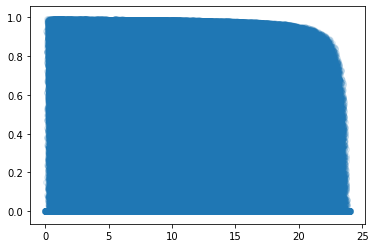

In [177]:
plt.scatter(driver_start_times_no_na['total_hour'], driver_start_times_no_na['inactive_time']/driver_start_times_no_na['diff'], alpha=0.1)

In [187]:
driver_start_times_no_na['ratio'] = driver_start_times_no_na['inactive_time']/driver_start_times_no_na['diff']
df_stats = driver_start_times_no_na.groupby(['hour']).agg(['mean', 'median', 'count'])

In [188]:
df_stats

diff                       new_diff                    total_hour  \
            mean     median   count        mean     median   count       mean   
hour                                                                            
0     253.268646  16.866667   77812  245.030099   6.533333   77812   0.636979   
1     270.811394  25.783333   77587  262.075905  15.450000   77587   1.459524   
2     264.782697  29.250000   50043  255.844033  18.916667   50043   2.464807   
3     237.084237  29.100000   31215  227.903142  18.766667   31215   3.467851   
4     203.603116  25.250000   27291  194.337907  14.916667   27291   4.470959   
5     175.484188  24.416667   22436  166.099800  14.083333   22436   5.523848   
6     128.159419  15.383333   37541  119.282536   5.050000   37541   6.561807   
7      69.423526  10.066667  134813   61.434551   0.000000  134813   7.629579   
8      65.748037   9.933333  273642   58.112775   0.000000  273642   8.533162   
9      79.098473  13.116667  301921   71.396935   2.783333  301921   9.518576   
10     71.377720  14.383333  311874   63.890396   4.050000  311874  10.498987   
11     62.952188  13.266667  314535   55.823357   2.933333  314535  11.504702   
12     55.886473  12.550000  313309   48.773599   2.216667  313309  12.497073   
13     44.492789   9.250000  335992   37.752867   0.000000  335992  13.515824   
14     43.399125   9.700000  357493   36.774055   0.000000  357493  14.496982   
15     41.617309  10.450000  328528   35.019527   0.116667  328528  15.492853   
16     40.205473  11.200000  296854   33.373730   0.866667  296854  16.495690   
17     33.391777   9.483333  297935   26.707194   0.000000  297935  17.504794   
18     28.311075   8.900000  306602   21.748731   0.000000  306602  18.499319   
19     28.032845   9.166667  269394   21.398914   0.000000  269394  19.497133   
20     23.862169   9.133333  249843   17.334165   0.000000  249843  20.497234   
21     18.422047   8.683333  229218   12.162970   0.000000  229218  21.489390   
22     12.771893   7.883333  181741    7.086913   0.000000  181741  22.470458   
23      7.587960   6.700000   96003    2.309619   0.000000   96003  23.390479   

                             lmbd                   inactive_time         \
         median   count      mean    median   count          mean median   
hour                                                                       
0      0.642778   77812  0.002324  0.002323   77812    140.044533   -0.0   
1      1.440278   77587  0.003190  0.003153   77587    168.574325   -0.0   
2      2.447500   50043  0.004562  0.004519   50043    183.765498   -0.0   
3      3.450278   31215  0.006336  0.006283   31215    174.640626   -0.0   
4      4.454722   27291  0.008549  0.008493   27291    155.804504   -0.0   
5      5.531944   22436  0.011358  0.011364   22436    135.468014   -0.0   
6      6.590278   37541  0.014568  0.014648   37541     98.347897   -0.0   
7      7.675278  134813  0.018226  0.018383  134813     49.010788   -0.0   
8      8.545833  273642  0.021482  0.021527  273642     47.006356   -0.0   
9      9.524167  301921  0.025024  0.025053  301921     58.426054   -0.0   
10    10.498333  311874  0.028340  0.028357  311874     51.487526   -0.0   
11    11.507222  314535  0.031296  0.031331  314535     44.721795   -0.0   
12    12.494167  313309  0.033555  0.033585  313309     38.605789   -0.0   
13    13.524167  335992  0.035007  0.035056  335992     29.868277   -0.0   
14    14.495000  357493  0.035461  0.035472  357493     28.806537   -0.0   
15    15.489722  328528  0.034935  0.034978  328528     26.739159   -0.0   
16    16.489167  296854  0.033444  0.033492  296854     24.735625   -0.0   
17    17.506944  297935  0.031098  0.031119  297935     19.201891   -0.0   
18    18.500000  306602  0.028136  0.028152  306602     14.628657   -0.0   
19    19.493889  269394  0.024739  0.024758  269394     12.909315   -0.0   
20    20.496944  249843  0.021135  0.021135  249843      8.727478   -0.0   


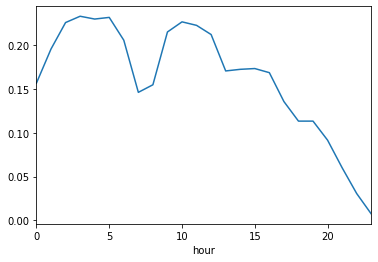

In [186]:
df_stats['ratio']['mean'].plot()

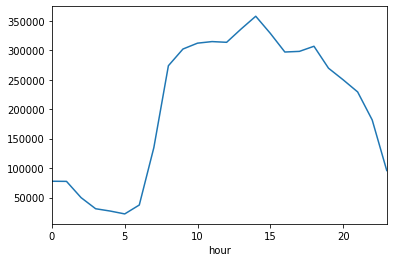

In [189]:
df_stats['ratio']['count'].plot()

In [30]:
orders = merged_orders[merged_orders.offpeak==True]
orders_offpeak = create_modified_active_time_through_decay(orders, use_cache=False)

Creating the exponential decay


In [31]:
orders = merged_orders[merged_orders.offpeak==False]
orders_peak = create_modified_active_time_through_decay(orders, use_cache=False)

Creating the exponential decay


In [32]:
orders_offpeak.shape, orders_peak.shape

((479082, 4), (1045890, 4))

In [36]:
x = pd.concat([orders_peak, orders_offpeak], axis=0)

In [38]:
y = x.groupby('driver_id').sum().reset_index()

In [39]:
y

,driver_id,ride_duration,modified_active_time,inactive_time
0,0000131d486b69eb77ab6e9e7cca9f4c,75.583333,99.154241,5.895759
1,00002724a19c5f6a54ae8d60a378997e,34.800000,34.800000,0.000000
2,000042288ba964aa04d14869bd56efb6,73.083333,94.433333,0.000000
3,000049d47b79747ad9927ba1bf5f4126,195.883333,340.555955,274.477378
4,00005adc52a78e1630cfb50e4bd0f89e,67.150000,93.570392,24.479608
...,...,...,...,...
1181097,ffffd42b789066fd428488fd25fd97c3,249.900000,316.287177,169.062823
1181098,ffffd9e4d9c1bfd620474c0b9d8a9fc2,221.650000,290.441138,104.892195
1181099,ffffdceae35295a04b50d4725aa8b1c7,27.283333,27.283333,0.000000
1181100,ffffe1a18a45ee560fd024e998bde2cc,275.733333,487.003071,193.996929


In [65]:
1/57

0.017543859649122806

In [7]:
# Check all diffs in start and end times
driver_start_times = merged_orders.loc[:, ['driver_id', 'ride_start_timestamp', 'ride_stop_timestamp', 'order_id']]\
            .drop_duplicates()
driver_start_times.sort_values(['driver_id', 'ride_start_timestamp'],
                               inplace=True)
driver_start_times['stop_time_shifted'] = driver_start_times.groupby(
    'driver_id')['ride_stop_timestamp'].shift(1)
driver_start_times['diff'] = driver_start_times[
    'ride_start_timestamp'] - driver_start_times['stop_time_shifted']

In [8]:
driver_start_times.sort_values(['driver_id', 'ride_start_timestamp']).head(100)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
175165,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 11:57:05,2016-11-01 12:13:18,f727597b61fc2f0141aadecf2a3b5ee0,NaT,NaT
90347,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:33:05,2016-11-01 12:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 12:13:18,00:19:47
156956,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:58:45,2016-11-01 13:42:08,dd9b252638479fb784b705492bdf1a65,2016-11-01 12:49:04,00:09:41
2327,00002724a19c5f6a54ae8d60a378997e,2016-11-28 00:19:16,2016-11-28 00:54:04,03014caf7353cb92868d78b143bca071,NaT,NaT
64719,000042288ba964aa04d14869bd56efb6,2016-11-28 19:49:07,2016-11-28 20:00:58,504e0d59e3c0ae899a85c5e0551cb2b3,NaT,NaT
...,...,...,...,...,...,...
159084,0001681811178a09aa002f607c89735b,2016-11-28 21:57:31,2016-11-28 22:13:46,c465c5f4fd5cc991e08363014a94627b,2016-11-28 00:41:44,21:15:47
39259,00016e54648071044515d4ff3bd3ae18,2016-11-17 07:54:11,2016-11-17 08:39:17,30b9fd23e5665bf65486032031a11a36,NaT,NaT
134435,00016e54648071044515d4ff3bd3ae18,2016-11-17 13:19:47,2016-11-17 13:36:33,a671bbaf869d56a72c44153a536b654b,2016-11-17 08:39:17,04:40:30
58077,00016e54648071044515d4ff3bd3ae18,2016-11-17 13:40:27,2016-11-17 13:51:59,47dc5113cadb120b2e9d922ee2c96271,2016-11-17 13:36:33,00:03:54


In [9]:
driver_start_times_no_na = driver_start_times.dropna()

In [10]:
driver_start_times_no_na.shape

(4923622, 6)

In [11]:
driver_start_times_no_na['diff'] = driver_start_times_no_na['diff'].dt.total_seconds() / 60

In [12]:
driver_start_times_no_na.head()

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff
90347,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:33:05,2016-11-01 12:49:04,804a1a47f2b10dc36b7e909d9b977f02,2016-11-01 12:13:18,19.783333
156956,0000131d486b69eb77ab6e9e7cca9f4c,2016-11-01 12:58:45,2016-11-01 13:42:08,dd9b252638479fb784b705492bdf1a65,2016-11-01 12:49:04,9.683333
5326,000042288ba964aa04d14869bd56efb6,2016-11-28 20:10:49,2016-11-28 20:20:25,06c7c82d8b15810ce80c47d0d3243ee1,2016-11-28 20:00:58,9.850000
118578,000042288ba964aa04d14869bd56efb6,2016-11-28 20:27:49,2016-11-28 21:02:33,929d619cd18a44b9ecdd259d71a13f7f,2016-11-28 20:20:25,7.400000
34798,000042288ba964aa04d14869bd56efb6,2016-11-28 22:32:06,2016-11-28 22:41:15,2b2880e2eb541443e747ecc649f67861,2016-11-28 21:02:33,89.550000


In [13]:
driver_start_times_no_na.describe()

,diff
count,4.923622e+06
mean,5.726774e+01
std,1.435211e+02
min,-1.638500e+02
25%,5.433333e+00
50%,1.033333e+01
75%,3.720000e+01
max,1.418300e+03


The mean difference between two consecutive pickup times is skewed right because of many drivers taking overnight breaks between two rides. A better estimate for the value of $\tau$ is the median difference of times between rides

In [52]:
mean_diff = driver_start_times_no_na['diff'].mean()

In [20]:
tau = driver_start_times_no_na['diff'].median()

This can be used to estimate the scale paramater for the decay by which the probability of a driver staying online decreases

$$\tau + \frac{1}{\lambda} = E(diff)$$

In [53]:
lmbd = 1./(mean_diff - tau)

In [55]:
shape = 1./lmbd

In [56]:
shape

46.93440354140374

In [71]:
# Defining function to determine online staying probability of a driver after time t:
from scipy.stats import expon
def idle_time_est(t, tau, shape, size):
    
    # sample from time diff distribution
    t_s = tau + np.random.exponential(scale=shape, size=size)
    
    indicator = t <= t_s
    indicator = 1 - indicator
    i_time = t - t_s
    idle_time = indicator * i_time
    
    return idle_time

## Adding column for estimated idle times

In [75]:
size = driver_start_times_no_na.shape[0]
driver_start_times_no_na['idle_time'] = idle_time_est(driver_start_times_no_na['diff'], tau, shape, size=size)

In [79]:
driver_start_times_no_na.sample(100)

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff,idle_time
35105,574e8df406d05e4e5f353fbc1520817c,2016-11-07 20:31:40,2016-11-07 20:42:01,2f62597bb27c18664e313614d52107bb,2016-11-07 20:06:51,24.816667,5.901138
5761,bada66f956688bd25a705a7fa3a15341,2016-11-01 10:04:03,2016-11-01 10:42:11,081a04db52a230e02d399e9837cd3dfd,2016-11-01 09:54:34,9.483333,-0.000000
76975,9af662a1ca2e1285be1278d095acf838,2016-11-05 16:38:56,2016-11-05 17:14:55,5e4ef1d086a2599c3a381c8ab85f297d,2016-11-05 16:01:05,37.850000,24.571417
43872,3063486c7452bac26c1d4fcc330a3672,2016-11-03 16:18:53,2016-11-03 16:44:09,3ba145ee40bd6cc25770ccd6cd9183d4,2016-11-03 15:39:21,39.533333,3.574437
179804,a9b287e707efabf5cc326820c4ceb5f8,2016-11-23 21:50:06,2016-11-23 22:02:10,e151b82641d8ac3b12395371019bbaa6,2016-11-23 21:33:27,16.650000,-0.000000
...,...,...,...,...,...,...,...
76031,2d434c87eabc0512a1d21a2b5131d47a,2016-11-11 13:47:58,2016-11-11 14:28:58,5a61de2f4abaa59b4cbb015ad99f7052,2016-11-11 12:02:40,105.300000,-0.000000
184203,b4c11e3a04edef139de55a17537c5504,2016-11-14 21:53:04,2016-11-14 22:39:53,f0ef0009bc7cd448356269fc1539ed94,2016-11-14 21:49:38,3.433333,-0.000000
159084,fd793e89f89b94ea49dfc146e269ed66,2016-11-08 09:40:30,2016-11-08 10:15:57,d20cec0c116df9616ee85ad97e858689,2016-11-08 08:41:24,59.100000,-0.000000
79947,481d203b78d583e5e8e7a1dc3a692e39,2016-11-30 17:55:43,2016-11-30 18:14:56,5f188189ff4d8bd090ca9d67efaf83c5,2016-11-30 17:43:31,12.200000,-0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c27e96a90>]],
      dtype=object)

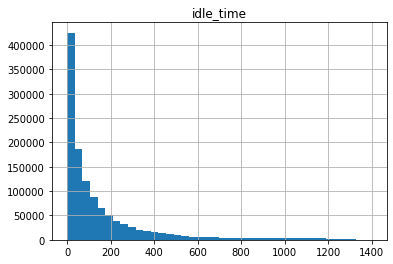

In [82]:
driver_start_times_no_na[driver_start_times_no_na.idle_time > 0].hist('idle_time', bins=40)

In [83]:
driver_start_times_no_na[driver_start_times_no_na.idle_time >= 1000]

,driver_id,ride_start_timestamp,ride_stop_timestamp,order_id,stop_time_shifted,diff,idle_time
159084,0001681811178a09aa002f607c89735b,2016-11-28 21:57:31,2016-11-28 22:13:46,c465c5f4fd5cc991e08363014a94627b,2016-11-28 00:41:44,1275.783333,1114.680950
58351,0008ddce4f6d06f0f49550b7bce8649a,2016-11-12 22:37:54,2016-11-12 22:53:24,46b5cc95a43646e1785ce203e9259359,2016-11-12 03:24:05,1153.816667,1127.138560
98527,000a89b924155f3ccf532c7e2de1c60a,2016-11-21 19:34:03,2016-11-21 19:57:05,7f3d9fe8b1a2178fcb5ef02b394a2532,2016-11-21 00:30:02,1144.016667,1075.794767
104602,000c63e7fdb9fd3589701a4a9d81eb1f,2016-11-11 20:25:04,2016-11-11 20:58:48,7c5a1a889dad8a362930135c736e2348,2016-11-11 01:38:04,1127.000000,1115.316032
86282,000e19b26e3a3be5d89d579ea69ccbe8,2016-11-28 22:12:16,2016-11-28 22:39:53,6ac19c9aba292ff102b4a5e025fe4e27,2016-11-28 00:24:51,1307.416667,1294.658388
...,...,...,...,...,...,...,...
188991,ffeb9840707131d88b2a8a1041c4108f,2016-11-25 21:58:02,2016-11-25 22:19:36,db05300ea3a97537f075da321a54c0eb,2016-11-25 02:24:48,1173.233333,1095.999703
173091,ffec57696c15eab20d5d76769793c117,2016-11-21 23:06:05,2016-11-21 23:15:48,dfe984800e0d56c4b6d3a607f1d32ef6,2016-11-21 00:52:59,1333.100000,1320.155754
173021,ffee1d4bf80293139718d8d4ebf99965,2016-11-12 22:14:52,2016-11-12 22:36:21,d23635931c57bbf830babed4915bbca5,2016-11-12 02:33:43,1181.150000,1149.113741
60169,fff54e25d5646aebfa5c38e62667b1a4,2016-11-09 23:12:29,2016-11-09 23:28:26,4f94ad7320f44cac754a378c299833c9,2016-11-09 02:42:38,1229.850000,1198.544461
